In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
def draw_edge_pair(x):
    plt.plot([x[0], x[2]], [x[1], x[3]])
    plt.plot([x[4], x[6]], [x[5], x[7]])
    
    
def are_edge_pairs_crossed(p):
    '''
    p - positions of n pairs edges in a [n,8] pytorch tensor, 
        where the postions of 8 nodes come in [ax, ay, bx, by, 
        cx, cy, dy, dy] for the edge pair a-b and c-d.
    
    return - an 1D tensor of boolean values, 
             where True means two edges cross each other. 
    '''
    p1, p2, p3, p4 = p[:,:2], p[:,2:4], p[:,4:6], p[:,6:]
    a = p2 - p1
    b = p3 - p4
    c = p1 - p3
    ax, ay = a[:,0], a[:,1]
    bx, by = b[:,0], b[:,1]
    cx, cy = c[:,0], c[:,1]
    
    denom = ay*bx - ax*by
    numer_alpha = by*cx-bx*cy
    numer_beta = ax*cy-ay*cx
    alpha = numer_alpha / denom
    beta = numer_beta / denom
    return torch.logical_and(
        torch.logical_and(0<alpha, alpha<1),
        torch.logical_and(0<beta, beta<1),
    )



class EdgePairDataset():
    def __init__(self, n=10000):
        super().__init__()
        self.n = n
        self.data = torch.rand(n, 8) * 2 - 1
        self.label = are_edge_pairs_crossed(self.data)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, i):
        return self.data[i], self.label[i]
    
    
    
class CrossingDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_dims = [8,96,256,96,1]
        self.layers = []
        for i, (in_dim, out_dim) in enumerate(zip(self.layer_dims[:-1], self.layer_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(self.layer_dims)-2:
                self.layers.append(nn.LeakyReLU())
                self.layers.append(nn.LayerNorm(out_dim))
            else:
                self.layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.main(x)
    
    



## Training

In [4]:
dataset = EdgePairDataset(n=int(1e6))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

device = 'cpu'
model = CrossingDetector().to(device)
bce = nn.BCELoss()
optmizer = optim.SGD(model.parameters(), lr=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

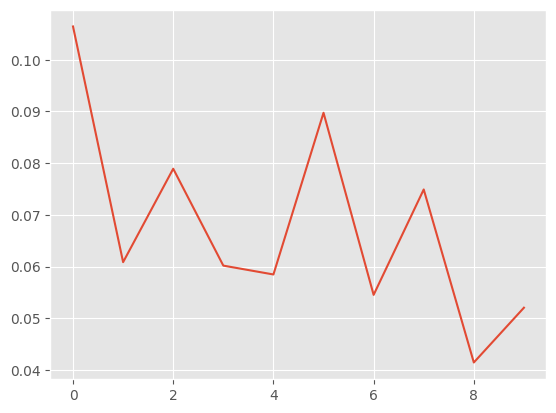

In [5]:


loss_curve = []
for epoch in tqdm(range(10)):
    for edge_pairs, targets in dataloader:
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        loss = bce(pred, targets.float().view(-1,1))

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
    loss_curve.append(loss.item())
    if epoch % 10 == 9:
        plt.plot(loss_curve)
        plt.show()


In [6]:
edge_pairs[1]

tensor([-0.7568,  0.3788,  0.3078,  0.9679, -0.7372,  0.8173, -0.5333, -0.3762])

## Acurracy

In [8]:
device = 'cpu'
# model = CrossingDetector().to(device)
# model.load_state_dict(torch.load('neural-crossing-detector.pth', map_location=device))

In [9]:
test_loader = DataLoader(EdgePairDataset(n=int(1e4)), batch_size=1024, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for edge_pairs, targets in tqdm(test_loader):
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        correct += ((pred>0.5) == targets.view(-1,1)).sum().item()
        total += len(targets)
        
#         ## vis
#         draw_edge_pair(edge_pairs[0])
#         plt.title(f'{pred[0].item()}/{targets[0].item()}')
#         plt.xlim([0,1])
#         plt.ylim([0,1])
#         plt.show()
print(f'{correct}/{total} {correct/total}')

  0%|          | 0/10 [00:00<?, ?it/s]

9793/10000 0.9793


## Test in Rome_1

In [179]:
import itertools
import torch
import networkx as nx
import os
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [95]:
def evaluate_edge_pairs(edge_pairs, batch_size=1024):
    results = []
    batch = []

    for pair in edge_pairs:
        ((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)) = pair
        batch.append([x1, y1, x2, y2, x3, y3, x4, y4])

        if len(batch) == batch_size:
            batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
            preds = model(batch_tensor).detach().cpu().numpy()
            results.extend(np.round(preds).astype(int))
            batch = []

    if batch:
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
        preds = model(batch_tensor).detach().cpu().numpy()
        results.extend(np.round(preds).astype(int))

    return results

def load_graphs(folder_path):
    """Loads GraphML files into NetworkX graph objects."""
    dataset = []
    for file in os.listdir(folder_path):
        if file.endswith(".graphml"):
            file_path = os.path.join(folder_path, file)
            try:
                graph = nx.read_graphml(file_path)
                dataset.append((file, graph))
            except Exception as e:
                print(f"Error loading {file}: {e}")

    return dataset

def preprocess_graphs(graphs):
    edge_pairs = []
    targets = []
    graph_ids = []
    graph_crossings = {}  # Stores total crossings per graph

    for file_name, graph in graphs:
        edges = [((graph.nodes[u]['x_pos'], graph.nodes[u]['y_pos']),
                  (graph.nodes[v]['x_pos'], graph.nodes[v]['y_pos']))
                 for u, v in graph.edges()]
        
        all_edge_pairs = list(itertools.combinations(edges, 2))
        crossing_results = evaluate_edge_pairs(all_edge_pairs, batch_size=1024)
        
        # Store total crossings per graph
        graph_crossings[file_name] = sum(crossing_results)

        for (edge1, edge2), target in zip(all_edge_pairs, crossing_results):
            edge_features = [
                edge1[0][0], edge1[0][1], edge1[1][0], edge1[1][1],
                edge2[0][0], edge2[0][1], edge2[1][0], edge2[1][1]
            ]
            edge_pairs.append(edge_features)
            targets.append(target)  # Store crossing info per edge pair
            graph_ids.append(file_name)  # Associate edge pair with graph filename

    return torch.tensor(edge_pairs), torch.tensor(targets), graph_ids, graph_crossings


class EdgePairDataset(Dataset):
    def __init__(self, edge_pairs, targets, graph_ids):
        self.edge_pairs = edge_pairs
        self.targets = targets
        self.graph_ids = graph_ids  # Add graph IDs

    def __len__(self):
        return len(self.edge_pairs)

    def __getitem__(self, idx):
        return self.edge_pairs[idx], self.targets[idx], self.graph_ids[idx]  # Return graph ID

tensor([[ 0.4419, -0.6522,  0.1904,  ...,  0.1579,  0.4902, -0.1840],
        [ 0.4419, -0.6522,  0.1904,  ...,  0.1579,  0.3279,  0.4042],
        [ 0.4419, -0.6522,  0.1904,  ...,  0.1579,  0.9195,  0.2565],
        ...,
        [ 0.0059, -0.4611, -0.2357,  ..., -0.4611,  0.2748, -0.5619],
        [ 0.0059, -0.4611, -0.2357,  ...,  0.3319,  0.2464,  0.0446],
        [ 0.0059, -0.4611,  0.2748,  ...,  0.3319,  0.2464,  0.0446]])

 45%|████▌     | 9/20 [00:40<00:48,  4.43s/it]

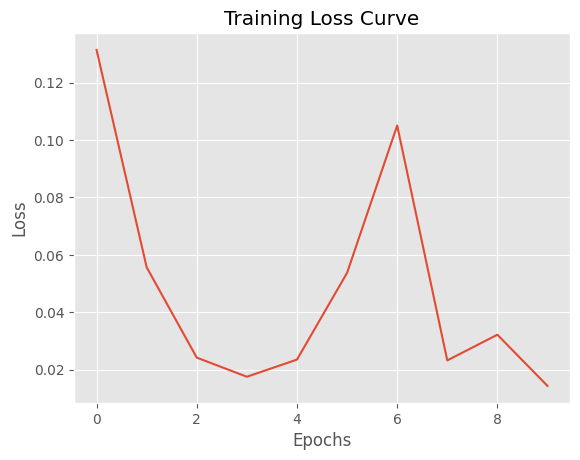

 95%|█████████▌| 19/20 [01:24<00:04,  4.46s/it]

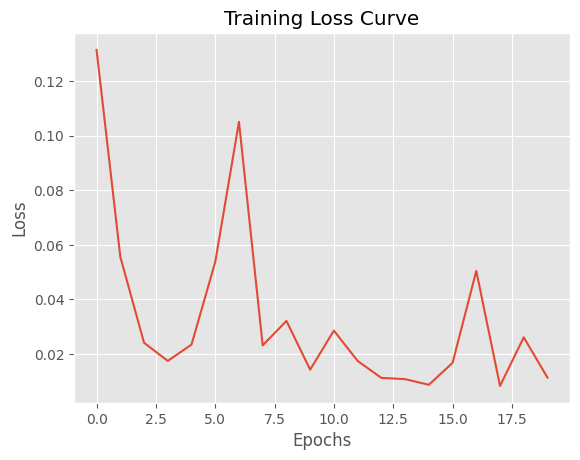

100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


In [135]:




# Split dataset into 80% train and 20% test
random.shuffle(graphs)
split_index = int(0.8 * len(graphs))
train_graphs = graphs[:split_index]
test_graphs = graphs[split_index:]




# Create training and test datasets
train_data, train_targets, train_graph_ids, train_graph_crossings = preprocess_graphs(train_graphs)
test_data, test_targets, test_graph_ids, test_graph_crossings = preprocess_graphs(test_graphs)

train_dataset = EdgePairDataset(train_data, train_targets, train_graph_ids)
test_dataset = EdgePairDataset(test_data, test_targets, test_graph_ids)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


# Model setup
device = 'cpu'
model = CrossingDetector().to(device)
bce = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
loss_curve = []
for epoch in tqdm(range(10)):
    for edge_pairs, targets, _ in train_loader:  # Unpack graph_ids but ignore it using '_'
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        loss = bce(pred, targets.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_curve.append(loss.item())

    # Plot loss every 10 epochs
    if epoch % 10 == 9:
        plt.plot(loss_curve)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.show()






In [181]:
correct_graphs = 0
total_graphs = len(test_graphs)
threshold = 0.5  # Binary classification threshold

graph_predictions = {}  # Stores aggregated predictions per graph
graph_targets = test_graph_crossings  # Use stored crossing counts

with torch.no_grad():
    for edge_pairs, targets, graph_ids in test_loader:
        edge_pairs, targets = edge_pairs.to(device), targets.to(device)
        pred = model(edge_pairs)
        pred =  pred.round() 

        for i in range(len(edge_pairs)):
            graph_id = graph_ids[i]
            if graph_id not in graph_predictions:
                graph_predictions[graph_id] = []

            graph_predictions[graph_id].append(pred[i].item())
        total_graphs += 1

# Compute graph-level predictions
final_preds = {}
for graph_id, edge_preds in graph_predictions.items():
    final_preds[graph_id] = round(sum(edge_preds))  # Predict total crossings by summing


actual_values = list(graph_targets.values())  # True number of crossings per graph
predicted_values = [final_preds[gid] for gid in graph_targets]  # Predicted number of crossings

# Compute R² Score
r2 = r2_score(actual_values, predicted_values)

# Compute Spearman Correlation
spearman_corr, _ = spearmanr(actual_values, predicted_values)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Compute Accuracy with Tolerances
correct = sum(1 for gid in graph_targets if abs(final_preds[gid] - graph_targets[gid]) == 0)
correct_tolerance_1 = sum(1 for gid in graph_targets if abs(final_preds[gid] - graph_targets[gid]) <= 1)
correct_tolerance_3 = sum(1 for gid in graph_targets if abs(final_preds[gid] - graph_targets[gid]) <= 3)

print(f"R² Score: {r2:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Accuracy : {correct / total_graphs * 100:.2f}%")
print(f"Accuracy (Tolerance 1): {correct_tolerance_1 / total_graphs * 100:.2f}%")
print(f"Accuracy (Tolerance 3): {correct_tolerance_3 / total_graphs * 100:.2f}%")




R² Score: 0.9954
Spearman Correlation: 0.9954
RMSE: 2.0264
Accuracy : 33.33%
Accuracy (Tolerance 1): 58.97%
Accuracy (Tolerance 3): 72.65%


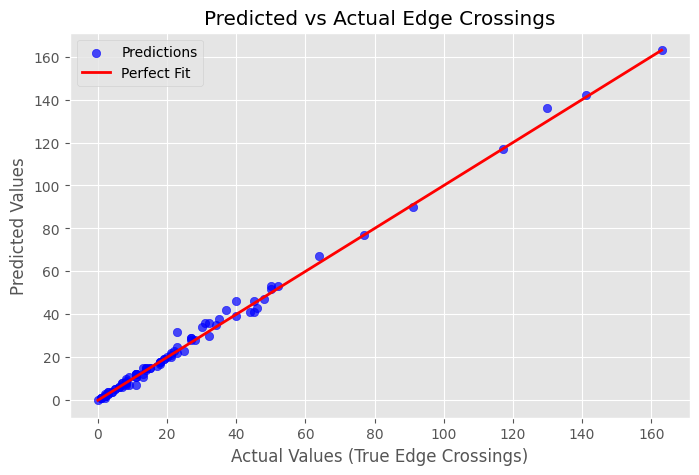

In [175]:
# Extract actual and predicted values from stored data
actual_values = list(graph_targets.values())  # True number of crossings per graph
predicted_values = [final_preds[gid] for gid in graph_targets]  # Predicted number of crossings

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(actual_values, predicted_values, alpha=0.7, label="Predictions", color="blue")

# Plot the perfect fit line (y = x)
x_line = np.linspace(min(actual_values), max(actual_values), 100)
plt.plot(x_line, x_line, color="red", linewidth=2, label="Perfect Fit")

# Labels and title
plt.xlabel("Actual Values (True Edge Crossings)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Edge Crossings")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
